# Headline

Beschreibung

### Daten

## 1. EDA

#### Imports

In [44]:
# suppress matplotlib inline warnings
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import json
import logging
import os
import shapely
import cv2
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

DEBUG:matplotlib.pyplot:Loaded backend module://ipykernel.pylab.backend_inline version unknown.


#### Config

In [10]:
logging.basicConfig(level=logging.DEBUG)

# Setting up File Paths
dirname = os.getcwd()
filename_val_bounding_boxes = os.path.join(dirname, 'val/via_region_data.json')
filename_train_bounding_boxes = os.path.join(dirname, 'train/via_region_data.json')

#### Loading Ground Truth

In [11]:
with open(filename_train_bounding_boxes, 'r') as f:
  train_bounding_boxes = json.load(f)

In [12]:
len(train_bounding_boxes)

52

In [13]:
train_bounding_boxes

{'test_pattern_qbist.jpg129855': {'fileref': '',
  'size': 129855,
  'filename': 'test_pattern_qbist.jpg',
  'base64_img_data': '',
  'file_attributes': {},
  'regions': {}},
 'a_swan_swimming_in_geneve_lake.jpg62201': {'fileref': '',
  'size': 62201,
  'filename': 'a_swan_swimming_in_geneve_lake.jpg',
  'base64_img_data': '',
  'file_attributes': {},
  'regions': {}},
 'sinus_test_pattern.jpg27894': {'fileref': '',
  'size': 27894,
  'filename': 'sinus_test_pattern.jpg',
  'base64_img_data': '',
  'file_attributes': {},
  'regions': {}},
 'image67.jpg47277': {'fileref': '',
  'size': 47277,
  'filename': 'image67.jpg',
  'base64_img_data': '',
  'file_attributes': {},
  'regions': {'0': {'shape_attributes': {'name': 'polygon',
     'all_points_x': [298, 327, 346, 369, 522, 512, 488, 393, 307, 288, 298],
     'all_points_y': [199, 203, 241, 265, 246, 290, 320, 322, 318, 264, 199]},
    'region_attributes': {'name': 'damage'}},
   '1': {'shape_attributes': {'name': 'polygon',
     'all_

In [14]:
train_df = pd.DataFrame.from_dict(train_bounding_boxes)
train_df = train_df.transpose().reset_index()
# Remove first three rows as they contain images that are not actually in the dataset
train_df = train_df.iloc[3: , :].reset_index(drop=True)

In [15]:
train_df.head()

,index,fileref,size,filename,base64_img_data,file_attributes,regions
0,image67.jpg47277,,47277,image67.jpg,,{},"{'0': {'shape_attributes': {'name': 'polygon',..."
1,image66.jpg19024,,19024,image66.jpg,,{},"{'0': {'shape_attributes': {'name': 'polygon',..."
2,image65.jpg102144,,102144,image65.jpg,,{},"{'0': {'shape_attributes': {'name': 'polygon',..."
3,image64.jpg85335,,85335,image64.jpg,,{},"{'0': {'shape_attributes': {'name': 'polygon',..."
4,image63.jpg24447,,24447,image63.jpg,,{},"{'0': {'shape_attributes': {'name': 'polygon',..."


Check data for duplicates.

In [16]:
sum(train_df.duplicated(subset=['index','filename']))

0

Calculate average image size.

In [17]:
train_df['size'].mean()

137704.306122449

Columns fileref, size, base64_img_data and file_attributes where identified to be either empty or not relevant to the given task and were therfore dropped to simplify the dataframe.

In [18]:
train_df = train_df.drop(['index', 'fileref', 'size', 'base64_img_data', 'file_attributes'], axis=1)

In [19]:
train_df.head()

,filename,regions
0,image67.jpg,"{'0': {'shape_attributes': {'name': 'polygon',..."
1,image66.jpg,"{'0': {'shape_attributes': {'name': 'polygon',..."
2,image65.jpg,"{'0': {'shape_attributes': {'name': 'polygon',..."
3,image64.jpg,"{'0': {'shape_attributes': {'name': 'polygon',..."
4,image63.jpg,"{'0': {'shape_attributes': {'name': 'polygon',..."


Expand 'regions' dict to examine structure of the training data.

In [60]:
 train_df['regions'].apply(pd.Series).head()

,0,1,2,3,4
0,"{'shape_attributes': {'name': 'polygon', 'all_...","{'shape_attributes': {'name': 'polygon', 'all_...",NaN,NaN,NaN
1,"{'shape_attributes': {'name': 'polygon', 'all_...",NaN,NaN,NaN,NaN
2,"{'shape_attributes': {'name': 'polygon', 'all_...",NaN,NaN,NaN,NaN
3,"{'shape_attributes': {'name': 'polygon', 'all_...",NaN,NaN,NaN,NaN
4,"{'shape_attributes': {'name': 'polygon', 'all_...",NaN,NaN,NaN,NaN


In [20]:
 train_df['regions'].apply(pd.Series)['0'][23]

{'shape_attributes': {'name': 'polygon',
  'all_points_x': [226, 175, 160, 164, 174, 189, 197, 218, 236, 226],
  'all_points_y': [62, 139, 178, 202, 207, 181, 138, 117, 80, 62]},
 'region_attributes': {'name': 'damage'}}

Analyse the maximum number of points used for the polygon throughout the dataset.

In [124]:
resolution_of_polygons = []

for row in train_df['regions']:
    for region in row.values():
        resolution_of_polygons.append(len(region['shape_attributes']['all_points_x']))

max(resolution_of_polygons)
sum(resolution_of_polygons) / len(resolution_of_polygons)

13.602564102564102

#### Displaying Examples for Bounding Boxes from the Training Set

In [107]:
def show_bounding_box(regions: dict, img_path: str)-> None:
    image = cv2.imread(img_path)
    isClosed = True
    color = (255,23,200)
    thickness = 3
        
    regions = list(regions)
    # remove nan from list
    regions = [x for x in regions if str(x) != 'nan']

    # draw polygon for all regions
    for region in regions:
        x = region['shape_attributes']['all_points_x']
        y = region['shape_attributes']['all_points_y']

        poly = np.array(list(zip(x, y)), np.int32)
        
        
        cv2.polylines(image, [poly], isClosed, color, thickness)
    
    plt.imshow(image)
    plt.show()

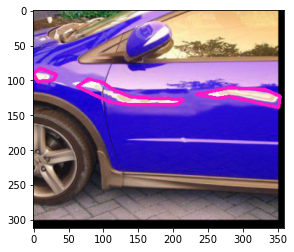

In [109]:
SAMPLE_INDEX = 43

show_bounding_box(regions=train_df['regions'].apply(pd.Series).loc[SAMPLE_INDEX], 
                  img_path=os.path.join(dirname, 'train', train_df['filename'].loc[SAMPLE_INDEX]))

## 2. Data Preperation

Resize images and bounding boxes

In [125]:
# Code for resizing by Aakanksha NS @ https://towardsdatascience.com/bounding-box-prediction-from-scratch-using-pytorch-a8525da51ddc

def create_mask(bb, x):
    """Creates a mask for the bounding box of same shape as image"""
    rows,cols,*_ = x.shape
    Y = np.zeros((rows, cols))
    bb = bb.astype(np.int)
    Y[bb[0]:bb[2], bb[1]:bb[3]] = 1.
    return Y

def mask_to_bb(Y):
    """Convert mask Y to a bounding box, assumes 0 as background nonzero object"""
    cols, rows = np.nonzero(Y)
    if len(cols)==0: 
        return np.zeros(4, dtype=np.float32)
    top_row = np.min(rows)
    left_col = np.min(cols)
    bottom_row = np.max(rows)
    right_col = np.max(cols)
    return np.array([left_col, top_row, right_col, bottom_row], dtype=np.float32)

def create_bb_array(x):
    """Generates bounding box array from a train_df row"""
    return np.array([x[5],x[4],x[7],x[6]])

def resize_image_bb(read_path,write_path,bb,sz):
    """Resize an image and its bounding box and write image to new path"""
    im = read_image(read_path)
    im_resized = cv2.resize(im, (int(1.49*sz), sz))
    Y_resized = cv2.resize(create_mask(bb, im), (int(1.49*sz), sz))
    new_path = str(write_path/read_path.parts[-1])
    cv2.imwrite(new_path, cv2.cvtColor(im_resized, cv2.COLOR_RGB2BGR))
    return new_path, mask_to_bb(Y_resized)

In [ ]:
for image in train_df:
    resize_image_bb(read_path=os.path.join(dirname, 'train', image['filename']),
                   write_path=os.path.join(dirname, 'train_resized', image['filename']),
                   image[])

Normalize Inputs

In [126]:
!pip install imutils

  Created wheel for imutils: filename=imutils-0.5.4-py3-none-any.whl size=25860 sha256=923e4c9f7711ceb08522ad0109e1555cacbe84502a0edec9175f72eccee45b3d
  Stored in directory: /Users/imax/Library/Caches/pip/wheels/59/1b/52/0dea905f8278d5514dc4d0be5e251967f8681670cadd3dca89
Successfully built imutils


Data Augmentation

## 3. Training the Classifier

Train-Test-Split was already taken care of.

Preparing the data
resizing

restricting bounding box to x coordinates

## 4. Evaluating the Results

further considerations
using pretrained model
using images without damage


possible challanges